In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [94]:
color_path = '../test_imgs/camo.jpg'
img_path = '../test_imgs/jacket.jpg'
mask_path = '../test_imgs/jacket_mask.bmp'


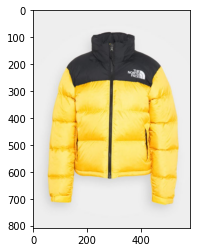

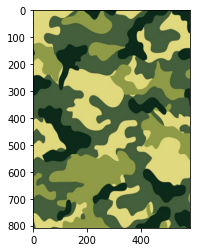

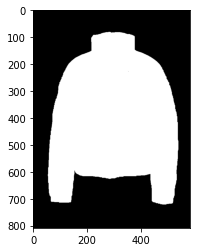

In [95]:
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
color = cv2.imread(color_path)
color = cv2.resize(color, (img.shape[1], img.shape[0]))
plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
plt.show()
mask = cv2.imread(mask_path)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.show()

In [96]:
# prepare values for color multiplication
mask = np.where(mask == 255, 1, 0)
mask_complement = np.where(mask == 0, 1, 0)

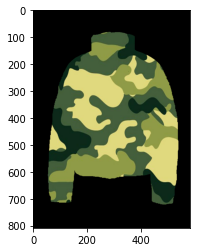

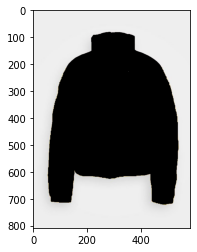

In [97]:
mask_colored = mask * color
plt.imshow(cv2.cvtColor(np.float32(mask_colored/255), cv2.COLOR_BGR2RGB))
plt.show()
# to preserve the background
mask_complement_colored = mask_complement * img
plt.imshow(cv2.cvtColor(np.float32(mask_complement_colored/255), cv2.COLOR_BGR2RGB))
plt.show()

In [98]:
# bah
img = img.astype('uint8')
mask_colored = mask_colored.astype('uint8')
mask = mask.astype('uint8')
img_colored = img.copy()

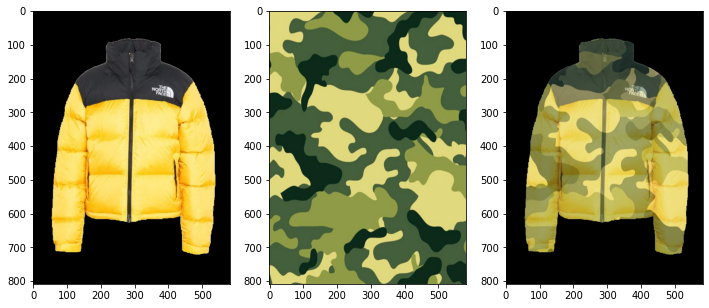

In [99]:
# weighted sum
img_colored = cv2.addWeighted(img, 0.5, mask_colored, 0.5, 0, -1)

fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(cv2.cvtColor(img * mask, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(img_colored * mask, cv2.COLOR_BGR2RGB))

# Adddetails to colored mask

In [39]:
color_path = '../test_imgs/camo.jpg'
img_path = '../test_imgs/jacket.jpg'
mask_path = '../test_imgs/jacket_mask.bmp'
details_path ='../test_imgs/jacket_details.jpg'

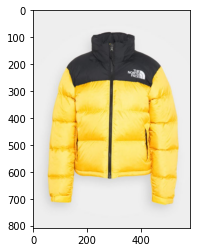

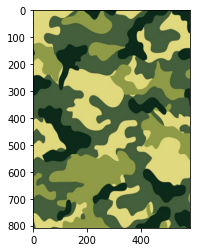

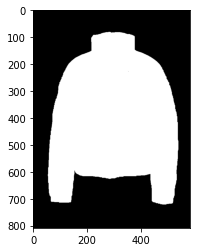

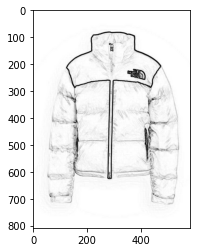

In [87]:
# read images
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
color = cv2.imread(color_path)
color = cv2.resize(color, (img.shape[1], img.shape[0]))
plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
plt.show()
mask = cv2.imread(mask_path)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.show()
details = cv2.imread(details_path)
plt.imshow(cv2.cvtColor(details, cv2.COLOR_BGR2RGB))
plt.show()

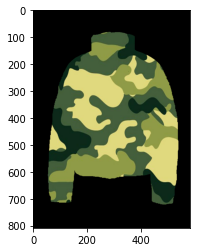

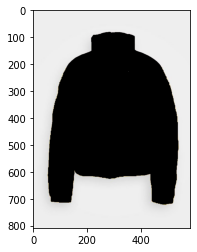

In [88]:
# prepare values for color multiplication
mask = np.where(mask == 255, 1, 0)
mask_complement = np.where(mask == 0, 1, 0)
mask_colored = mask * color
plt.imshow(cv2.cvtColor(np.float32(mask_colored/255), cv2.COLOR_BGR2RGB))
plt.show()
# to preserve the background
mask_complement_colored = mask_complement * img
plt.imshow(cv2.cvtColor(np.float32(mask_complement_colored/255), cv2.COLOR_BGR2RGB))
plt.show()
# bah
img = img.astype('uint8')
mask_colored = mask_colored.astype('uint8')
mask = mask.astype('uint8')
details = details.astype('uint8')
img_colored = mask_colored.copy()

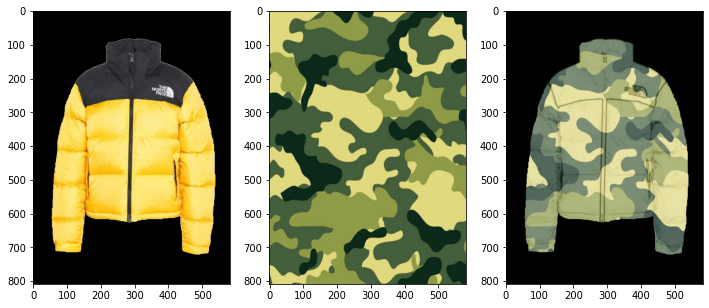

In [120]:
# weighted sum
img_colored = cv2.addWeighted(mask_colored, 0.7, details, 0.3, 0, -1)

fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(cv2.cvtColor(img * mask, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(img_colored * mask, cv2.COLOR_BGR2RGB))

In [77]:
# # convert to ycbcr
# details_ycbcr = cv2.cvtColor(details, cv2.COLOR_BGR2YCR_CB)
# img_colored_ycbcr = cv2.cvtColor(img_colored, cv2.COLOR_BGR2YCR_CB)

In [84]:
# # add details to colored mask
# img_colored_ycbcr[:,:,0] = details_ycbcr[:,:,0]

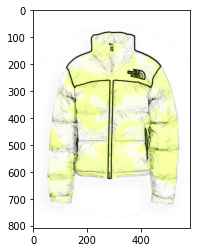

In [83]:
# plt.imshow(cv2.cvtColor(img_colored_ycbcr, cv2.COLOR_YCR_CB2RGB))

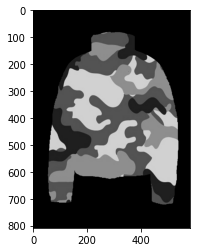

In [71]:
# plt.imshow(cv2.cvtColor(details_ycbcr, cv2.COLOR_YCR_CB2RGB))